In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

In [4]:
df1=pd.read_csv('traffic_training.csv')

In [5]:
df1.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

In [6]:
df1.groupby('geohash6').count().sample(n=10)

,day,timestamp,demand
geohash6,,,
qp096w,5781,5781,5781
qp092q,5843,5843,5843
qp09y4,436,436,436
qp03pk,2214,2214,2214
qp09vp,3121,3121,3121
qp09e8,4344,4344,4344
qp09b5,5735,5735,5735
qp0934,239,239,239
qp03xw,5846,5846,5846


In [51]:
df_sel = df1[(df1.geohash6=='qp06ph') &  (df1.day>=61)]
s=df_sel['timestamp']
f="%H:%M"
df_sel['timestamp'] = pd.to_datetime(s, format=f)
df_sel['hour'] = df_sel.timestamp.dt.hour
df_sel['minute'] = df_sel.timestamp.dt.minute
df_sel['demand*100'] = df_sel['demand']*100
df_sel.day=df_sel.day-60
df_sel.head(10)

,geohash6,day,timestamp,demand,hour,minute,demand*100
22853,qp06ph,1,1900-01-01 23:45:00,0.032385,23,45,3.238544
25323,qp06ph,1,1900-01-01 11:00:00,0.030710,11,0,3.071003
33316,qp06ph,1,1900-01-01 20:30:00,0.000618,20,30,0.061769
113774,qp06ph,1,1900-01-01 19:15:00,0.000849,19,15,0.084889
125149,qp06ph,1,1900-01-01 07:15:00,0.069031,7,15,6.903112
142406,qp06ph,1,1900-01-01 11:15:00,0.108514,11,15,10.851411
224513,qp06ph,1,1900-01-01 02:00:00,0.074434,2,0,7.443384
319557,qp06ph,1,1900-01-01 05:45:00,0.074010,5,45,7.400953
335257,qp06ph,1,1900-01-01 20:45:00,0.024358,20,45,2.435783
550973,qp06ph,1,1900-01-01 10:45:00,0.044488,10,45,4.448845


In [52]:
df_sel['n']=((df_sel.day-1)*96)+(df_sel.hour*4)+((df_sel.minute//15)+1)
df_sel.sort_values('n').head(10)

,geohash6,day,timestamp,demand,hour,minute,demand*100,n
2539021,qp06ph,1,1900-01-01 00:00:00,0.068303,0,0,6.830316,1
4066807,qp06ph,1,1900-01-01 00:15:00,0.065862,0,15,6.586216,2
1221016,qp06ph,1,1900-01-01 00:30:00,0.048406,0,30,4.840559,3
1700361,qp06ph,1,1900-01-01 00:45:00,0.033606,0,45,3.360595,4
1617920,qp06ph,1,1900-01-01 01:00:00,0.070934,1,0,7.093414,5
2980793,qp06ph,1,1900-01-01 01:15:00,0.080116,1,15,8.011615,6
2987598,qp06ph,1,1900-01-01 01:30:00,0.055079,1,30,5.507880,7
3533031,qp06ph,1,1900-01-01 01:45:00,0.096275,1,45,9.627451,8
224513,qp06ph,1,1900-01-01 02:00:00,0.074434,2,0,7.443384,9
3478618,qp06ph,1,1900-01-01 02:15:00,0.103380,2,15,10.338022,10


In [53]:
df_sel=df_sel.set_index('n').sort_index()
df_sel=df_sel[['demand*100']]
df_sel.head()

,demand*100
n,
1,6.830316
2,6.586216
3,4.840559
4,3.360595
5,7.093414


In [55]:
index=range(1,97)
index

columns=['demands']
df_null = pd.DataFrame(index=index, columns=columns)

In [57]:
df_for=df_null.join(df_sel)
df_for=df_for[['demand*100']].fillna(0)
df_for.head()

,demand*100
1,6.830316
2,6.586216
3,4.840559
4,3.360595
5,7.093414


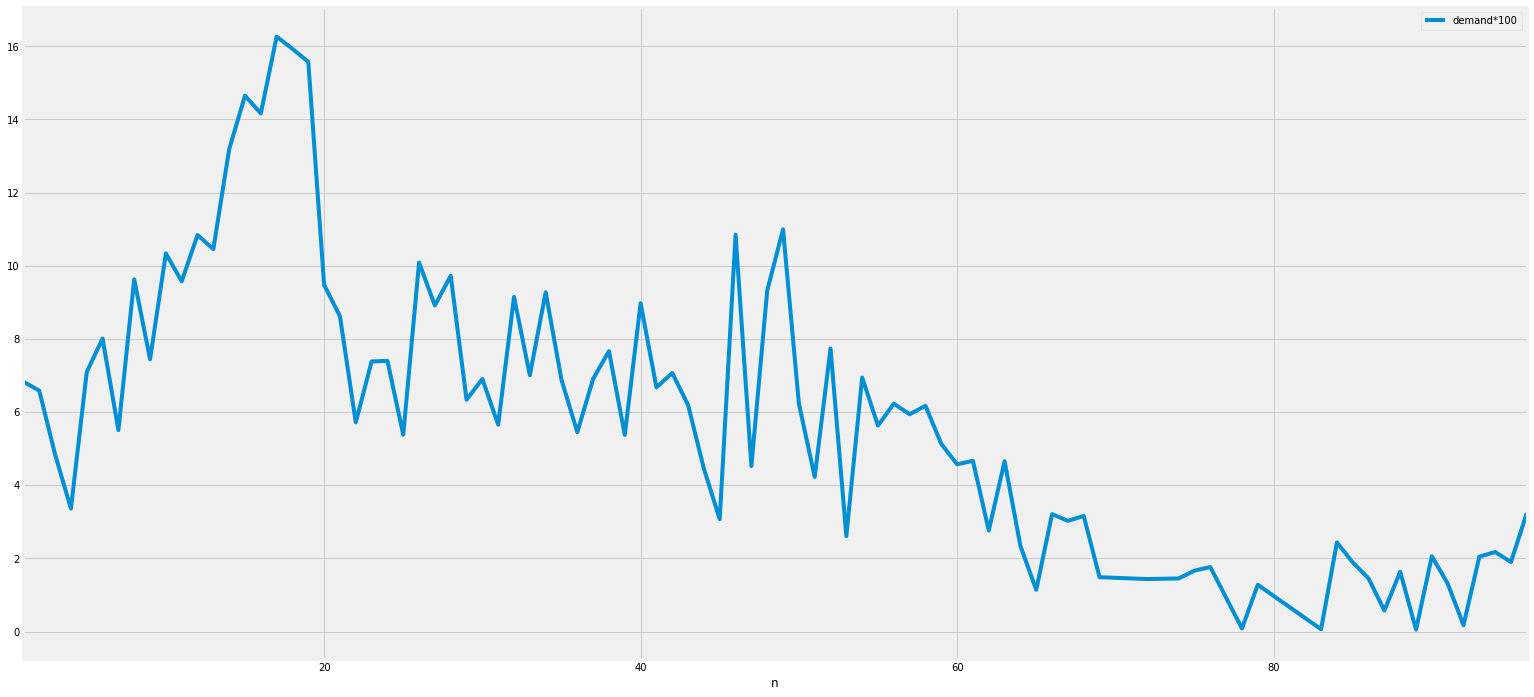

In [58]:
df_sel.plot(figsize=(24,12))

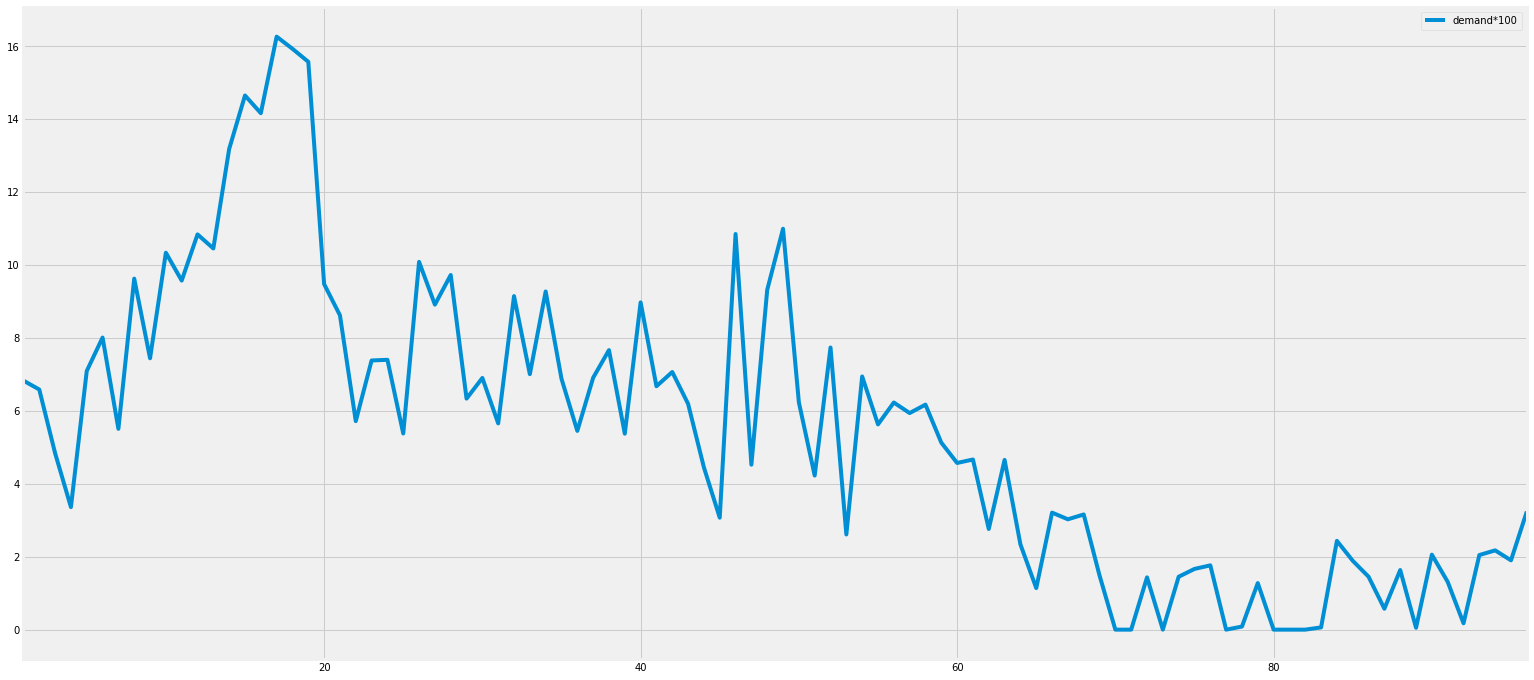

In [59]:
df_for.plot(figsize=(24,12))

In [60]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

In [61]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
arimaval=5000
count=0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_for,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        if results.aic<arimaval:  
            arimaval=results.aic
        else:
            arimaval=arimaval
        count+=1

ARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:636.072114229974
ARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:551.4044391253842
ARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:465.7727986593976
ARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:433.7568711785472
ARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:466.0491479935168
ARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:451.78496933754275
ARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:438.26936003438146
ARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:431.72622206014944
ARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:557.5478192591967
ARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:491.7803039963393
ARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:449.99705840145265
ARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:406.9272213791404
ARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:451.5507295288322
ARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:422.98391873000764
ARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:420.1776185261218
ARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:408.6359636707141
ARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:425.3847860282045
ARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:409.43511661349913
ARIMA(0, 1, 0)x(0, 1, 0, 4)4 - AIC:477.07

In [62]:
print(arimaval)

371.8437165767819


In [63]:
mod = sm.tsa.statespace.SARIMAX(df_for,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2799      0.217     -1.292      0.196      -0.705       0.145
ma.L1         -0.1988      0.202     -0.983      0.326      -0.595       0.197
ar.S.L4       -0.2480      0.123     -2.020      0.043      -0.489      -0.007
ma.S.L4       -1.0000   1650.378     -0.001      1.000   -3235.681    3233.681
sigma2         3.6290   5989.399      0.001      1.000   -1.17e+04    1.17e+04


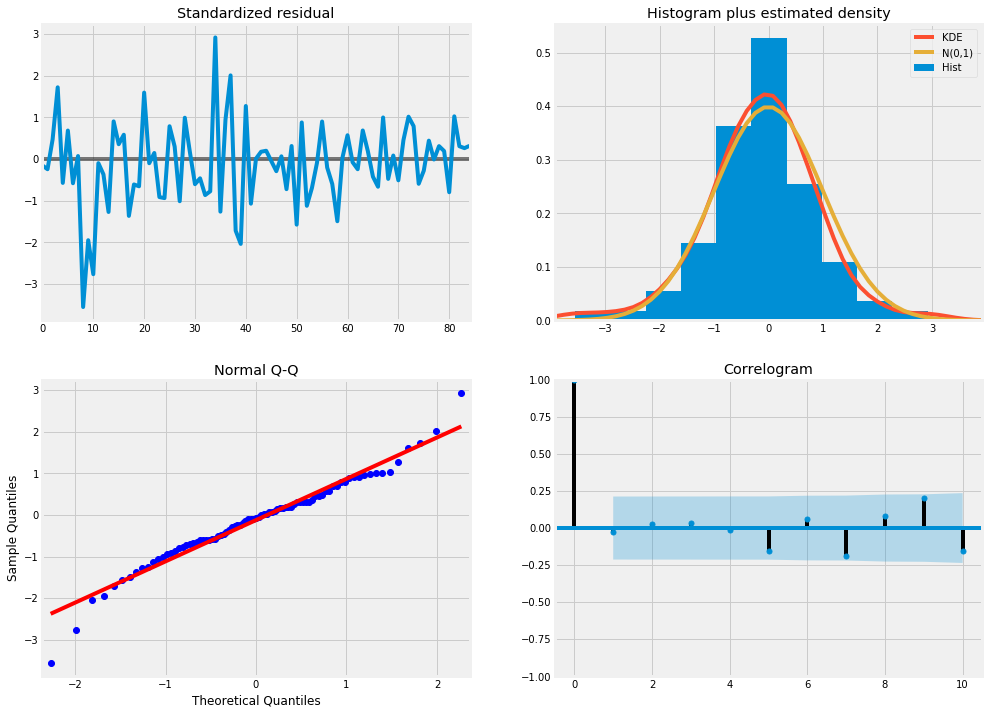

In [64]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [65]:
pred = results.get_prediction(start=80, dynamic=False)
pred_ci = pred.conf_int()
pred

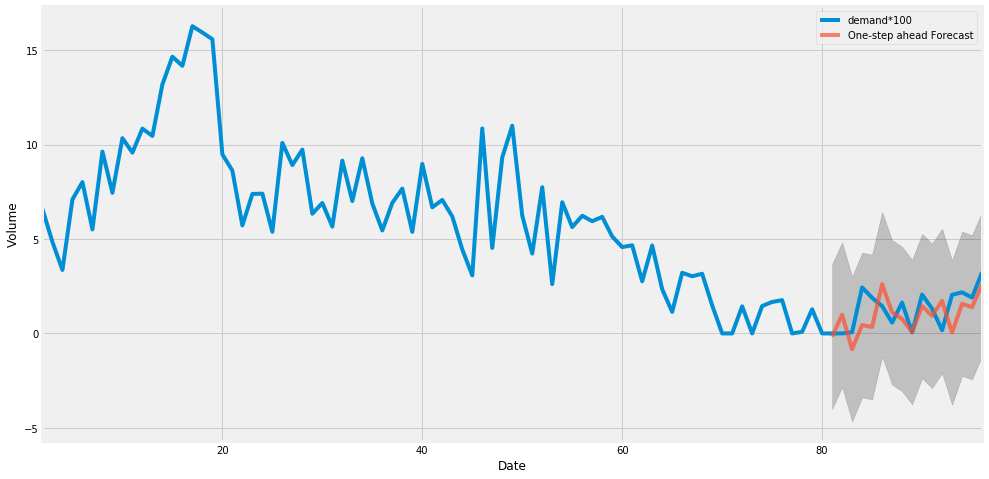

In [66]:
ax = df_for[1:].plot(label='observed', figsize=(15, 8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15, 8))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()

plt.show()

In [68]:
y_forecasted = pred.predicted_mean
y_truth = df_for['demand*100'][80:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.16


In [70]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=10)


# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

pred_ci1=pred_ci
pred_ci1['Forecast']=(pred_ci1['lower demand*100']+pred_ci1['upper demand*100'])/2
pred_ci1

,lower demand*100,upper demand*100,Forecast
97,-2.433571,5.200654,1.383541
98,-1.721349,6.886852,2.582751
99,-3.331229,6.622862,1.645816
100,-3.481624,7.531301,2.024838
101,-4.429829,7.047736,1.308953
102,-3.886396,8.251085,2.182344
103,-4.923384,7.777057,1.426837
104,-4.588954,8.666611,2.038829
105,-5.958836,8.042445,1.041804
106,-5.306000,9.297234,1.995617


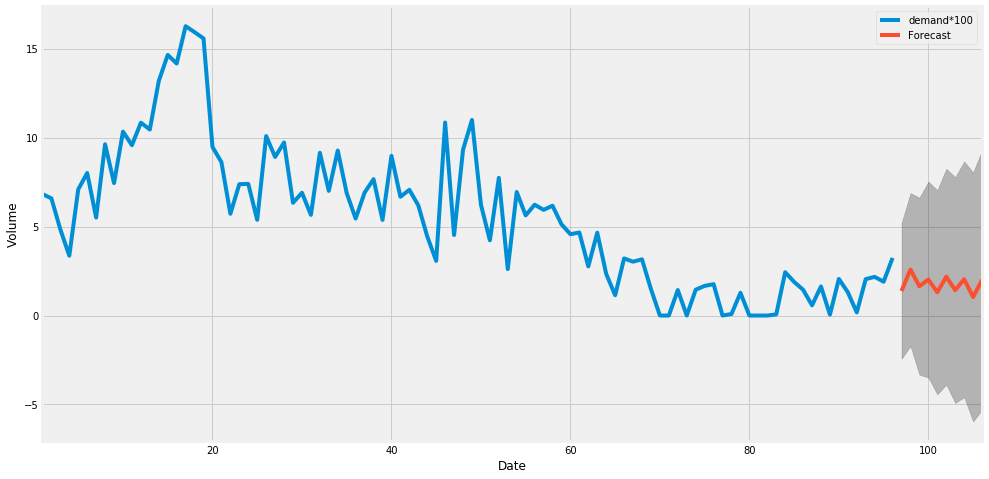

In [71]:
ax = df_for.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()